# Introduction to Machine Learning
## Home Assignment 1
## Imports

In [167]:
import requests
from zipfile import ZipFile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

## Data Preporcessing

In [168]:
# we get the data
_URL = 'http://www.di.ens.fr/appstat/spring-2020/project/data2.zip'
r = requests.get(_URL, allow_redirects=True)
with open('data2.zip', 'wb') as f:
    f.write(r.content)
with ZipFile('data2.zip', 'r') as zipObj:
    zipObj.extractall()


In [169]:
training_data_path = os.path.join('data2', 'train')
test_data_path = os.path.join('data2', 'test')

In [247]:
L = np.arange(900)
random.shuffle(L)
Y = np.arange(750)
random.shuffle(Y)
number_of_samples_per_letter = 300
pixel_height = 28
pixel_width = 28
number_of_pixels = pixel_height*pixel_width
batch_size = 50
shape = (pixel_height, pixel_width)
seed = 54
# We define a flow of images: 

def generate (dir_path): 
    training_data = []
    training_labels = []
    for item in os.listdir(dir_path):
        tmp = os.path.join(dir_path,item)
        if os.path.isdir(tmp):
            d, l = generate (tmp)
            training_data = training_data + d
            training_labels = training_labels + l
        elif tmp[-3:] == "png":
            im = Image.open(tmp)
            training_data.append(np.reshape(np.asarray(im), number_of_pixels))
            if(dir_path[-1:] == 'A'):
                training_labels.append(1)
            else: 
                training_labels.append(-1)
    return training_data, training_labels





            
def make (dir_path, s): 
    d, l = generate(dir_path)
    data = np.array(d)/255
    label = np.reshape(np.array(l), (np.shape(l)[0],1))
    return data[s], label[s]


training_data, training_labels = make(training_data_path, L)
test_data, test_labels = make(test_data_path, Y)


print(np.shape(training_data))
print(np.shape(training_labels))

(900, 784)
(900, 1)


## Utility functions 

In [283]:
def logistic_loss_lasso (theta, x, y, lambd): 
    return 1/np.shape(y)[0] * np.sum(np.log(1+np.exp(-y*(x@theta))), axis=0) + lambd*np.sum(np.abs(theta), axis=0)

def logistic_subgradient_lasso (theta, x, y, lambd):
    k = -y*x
    e = np.exp(k@theta)
    u_ = k*e
    return np.reshape(1/np.shape(y)[0] * np.sum(u_/(1+e), axis=0), np.shape(theta)) + lambd*(2*(theta>0) -1)

def logistic_gradient (theta, x, y):
    k = -y*x
    e = np.exp(k@theta)
    u_ = k*e
    return np.reshape(1/np.shape(y)[0] * np.sum(u_/(1+e), axis=0), np.shape(theta))


def S_lambda (x, lambd):
    def soft_thresh(x, l):
        return np.sign(x) * np.maximum(np.abs(x) - l, 0.)
    return np.vectorize (soft_thresh) (x, lambd)


    
#need to update it with logistic partial derivative not the OLS one
# def update_i_coordinate_lasso (theta, x, y, lambd, i):
#     x_i_T = np.reshape(x[:,i], (1, np.shape(y)[0]))
#     if (i > 0 and i < number_of_pixels):
#         x__i = np.hstack([x[:,:i], x[:,i+1:]])
#         theta_i = np.concatenate([theta[:i], theta[i+1:]])
#     elif (i == 0):
#         x__i  = x[:, 1:]
#         theta_i = theta[1:]
#     else: 
#         x__i = x[:, :(number_of_pixels - 1)]
#         theta_i = theta[:(number_pixels - 1)]
#     a = S_lambda(x_i_T@(y-(x_i_T@x__i@theta_i)), lambd)/(x_i_T@np.reshape(x[:,i], (np.shape(y)[0], 1)))
#     print(a)
#     return a
    
    
def logistic_loss_ridge (theta, x, y, lambd): 
    return 1/np.shape(y)[0] * np.sum(np.log(1+np.exp(-y*(x@theta))), axis=0) + lambd*np.sum(theta**2, axis=0)

def logistic_gradient_ridge (theta, x, y, lambd):
    k = -y*x
    e = np.exp(k@theta)
    u_ = k*e
    return np.reshape(1/np.shape(y)[0] * np.sum(u_/(1+e), axis=0), np.shape(theta)) + lambd*2*theta

def sigmoid(t):
    return 1/(1 + np.exp(-t))       

def logistic_classify(theta, data): 
    return 2*(sigmoid(data@theta)>0.5) - 1

def test(theta, data_set, labels): 
    accuracy = 0
    for x, y in zip (data_set, labels):
        accuracy += (logistic_classify(theta, x) == y) 
    return accuracy/len(labels)

def plot(training_error, test_error, t, t_s, title):
    plt.plot(t, training_error, label="training_error")
    plt.plot(t, test_error, label="test_error")
    plt.legend()
    plt.ylabel("error_rate")
    plt.xlabel(t_s)
    plt.title(title)
    plt.show(block=False)
    



## Gradient Descent and Coordinate Desecent

In [356]:
def gradient_descent_ridge (starting_point, training_data, training_labels, eta, t, lambd):
    theta = starting_point
    for i in range (t):
        delta_theta = -logistic_gradient_ridge(theta, training_data, training_labels, lambd)
        theta += eta*delta_theta
    return theta

# def subgradient_descent_lasso (starting_point, training_data, training_labels, eta, t, lambd):
#     theta = starting_point
#     best_theta = starting_point
#     for j in range(t):
#         delta_theta = -logistic_subgradient_lasso(theta, training_data, training_labels, lambd)
#         theta += eta*delta_theta
#         if (logistic_loss_lasso(theta, training_data, training_labels, lambd) > 
#             logistic_loss_lasso(best_theta, training_data, training_labels, lambd)):
#             best_theta = theta
            
#     return best_theta

# def gradient_descent_lasso_1 (starting_point, training_data, training_labels, eta, t, lambd):
#     theta = starting_point
#     for j in range(t):
#         delta_theta = -logistic_subgradient_lasso(theta, training_data, training_labels, lambd)
#         theta += eta*delta_theta
#         theta = S_lambda (theta, lambd/eta)
#     return theta


def ISTA (starting_point, training_data, training_labels, eta, t, lambd):
    theta = starting_point
    for j in range(t):
        delta_theta = -logistic_gradient(theta, training_data, training_labels)
        theta += eta*delta_theta
        theta = S_lambda (theta, lambd*eta)
    return theta

[0.94666667]
[0.94666667]
[0.94666667]
[0.94666667]
[0.94666667]
[0.94666667]
[0.94666667]
[0.94533333]
[0.94533333]
[0.94666667]
[0.948]
[0.94666667]
[0.94533333]
[0.944]
[0.94133333]
[0.94]
[0.936]
[0.932]
[0.93066667]
[0.92666667]
[0.928]
[0.928]
[0.92666667]
[0.92666667]
[0.92533333]
[0.924]
[0.924]
[0.92266667]
[0.92133333]
[0.91866667]
[0.916]
[0.91466667]
[0.90933333]
[0.904]
[0.90133333]
[0.89466667]
[0.88933333]
[0.88666667]
[0.884]
[0.864]


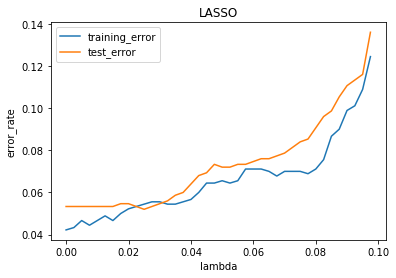

[0.93466667]
[0.936]
[0.936]
[0.936]
[0.936]
[0.936]
[0.936]
[0.936]
[0.936]
[0.936]
[0.93466667]
[0.93466667]
[0.936]
[0.93466667]
[0.93466667]
[0.936]
[0.93733333]
[0.936]
[0.93466667]
[0.93466667]
[0.93466667]
[0.93466667]
[0.93333333]
[0.93333333]
[0.93333333]
[0.932]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.93066667]
[0.92933333]
[0.928]
[0.92666667]
[0.92666667]
[0.92666667]
[0.92666667]


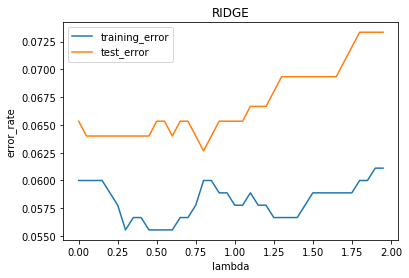

In [362]:
def evaluate (descent, title, starting, eta, lambda_max, t):
    training_errors = []
    test_errors = []
    lambdas = np.arange(0, lambda_max, lambda_max/t)
    for lambd in lambdas:
        theta = descent(starting*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, eta, 100, lambd)
        tmp = test(theta, test_data, test_labels)
        print(tmp)
        training_errors.append(test(theta, training_data, training_labels))
        test_errors.append(tmp)


    plot(1-np.array(training_errors), 1-np.array(test_errors), lambdas, "lambda", title)
    
    
evaluate(ISTA, "LASSO", 0.17, 0.1, 0.1, 40) #0.025 shows good lasso behavior
evaluate(gradient_descent_ridge, "RIDGE", 0.001, 0.01, 2, 40) #0.8 shows good ridge behavior

In [352]:
def K_fold(descent, K, lambd, eta, starting_point):
    n = np.shape(training_labels)[0]
    assert (n % K == 0)
    test_error = []
    for i in range(0, n, K):
            theta = descent(starting_point*np.ones((pixel_height*pixel_width, 1)), 
                            np.concatenate([training_data[:i], training_data[i+K:n]]), 
                            np.concatenate([training_labels[:i], training_labels[i+K:n]]),
                            eta, 100, lambd)
            
            test_error.append(test(theta, training_data[i:i+K], training_labels[i:i+K]))
    a = sum(test_error)/len(test_error)
    print(a)
    return a
                              
def choose_lambda (descent, starting_point, eta, lambda_max, t, K=90):
    l = np.array([K_fold(descent, K, i/t*lambda_max, eta, starting_point) for i in range(int(t))])
    plt.plot(np.arange(0, lambda_max, lambda_max/t), 1 - l, label="crossvalidation_error")
    plt.ylabel("error rate")
    plt.xlabel("lambda")
    plt.title("cross validation")
    plt.show(block=False)
    return np.argmax(l)/t*lambda_max

[0.93888889]
[0.93888889]
[0.93666667]
[0.93888889]
[0.93888889]
[0.94111111]
[0.93888889]
[0.93777778]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.94]
[0.94111111]
[0.94]
[0.94]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93888889]
[0.93777778]
[0.93555556]
[0.93333333]
[0.93222222]
[0.92666667]
[0.92555556]
[0.92555556]
[0.92555556]
[0.92333333]
[0.92222222]
[0.91777778]
[0.91444444]
[0.91333333]
[0.91333333]
[0.91333333]
[0.91333333]
[0.91222222]
[0.91111111]
[0.91111111]
[0.91111111]
[0.91111111]
[0.91]
[0.91]
[0.90888889]
[0.90555556]
[0.90555556]
[0.90555556]
[0.90444444]
[0.90333333]


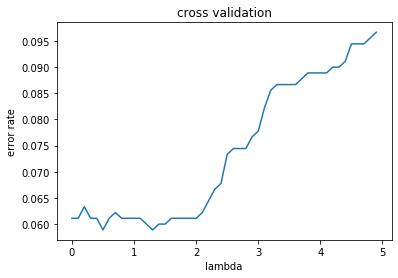

0.5

In [9]:
choose_lambda(gradient_descent_ridge, 0.001, 0.1, 2, 40)

[0.94444444]
[0.95111111]
[0.95222222]
[0.95222222]
[0.95444444]
[0.94888889]
[0.94555556]
[0.94666667]
[0.94666667]
[0.94555556]
[0.94111111]
[0.94111111]
[0.94]
[0.93777778]
[0.93666667]
[0.93666667]
[0.93444444]
[0.93333333]
[0.93444444]
[0.93666667]
[0.93777778]
[0.93555556]
[0.93777778]
[0.93666667]
[0.93777778]
[0.93888889]
[0.94111111]
[0.94]
[0.93333333]
[0.93222222]
[0.93111111]
[0.93]
[0.92666667]
[0.92111111]
[0.92]
[0.91222222]
[0.91]
[0.88888889]
[0.90444444]
[0.84444444]


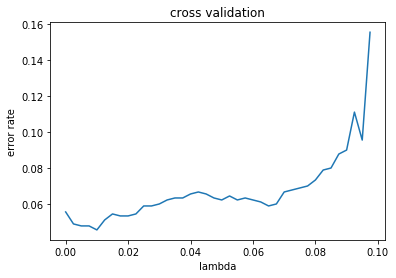

0.1

In [363]:
choose_lambda(ISTA, 0.17, 0.5, 0.1, 40)

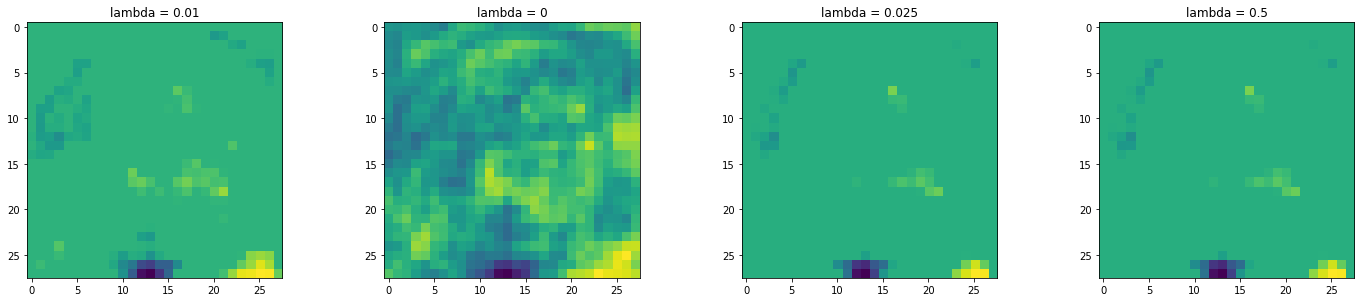

In [365]:
####LASSO#####

theta_L_opt = ISTA(0.17*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.5, 100, 0.01)
theta_L_zero = ISTA(0.17*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.5, 100, 0)
theta_L_three = ISTA(0.17*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.5, 100, 0.025)
theta_L_five = ISTA(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.5, 100, 0.5)

plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.imshow(np.reshape(theta_R_opt, shape))
plt.title("lambda = 0.01")
plt.subplot(2, 4, 2)
plt.imshow(np.reshape(theta_R_zero, shape))
plt.title("lambda = 0")
plt.subplot(2, 4, 3)
plt.imshow(np.reshape(theta_R_three , shape))
plt.title("lambda = 0.025")
plt.subplot(2, 4, 4)
plt.imshow(np.reshape(theta_R_three , shape))
plt.title("lambda = 0.5")

plt.tight_layout()

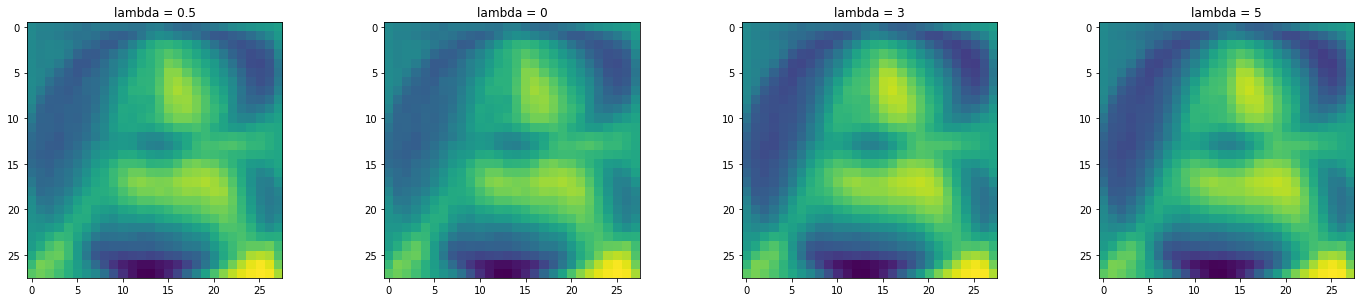

In [368]:
#####RIDGE#####
theta_R_opt = gradient_descent_ridge(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.01, 100, 0.5)
theta_R_zero = gradient_descent_ridge(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.01, 100, 0)
theta_R_three = gradient_descent_ridge(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.01, 100, 3)
theta_R_five = gradient_descent_ridge(0.001*np.ones((pixel_height*pixel_width, 1)), training_data, training_labels, 0.01, 100, 5)

plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.imshow(np.reshape(theta_R_opt, shape))
plt.title("lambda = 0.5")
plt.subplot(2, 4, 2)
plt.imshow(np.reshape(theta_R_zero, shape))
plt.title("lambda = 0")
plt.subplot(2, 4, 3)
plt.imshow(np.reshape(theta_R_three , shape))
plt.title("lambda = 3")
plt.subplot(2, 4, 4)
plt.imshow(np.reshape(theta_R_three , shape))
plt.title("lambda = 5")

plt.tight_layout()

## K means

In [248]:
labels_training = np.array([1 for i in range(300)] + [0 for i in range(300)] + [2 for i in range(300)])[L]
labels_test = np.array([1 for i in range(250)] + [0 for i in range(250)] + [2 for i in range(250)])[Y]
labels = np.concatenate([labels_training, labels_test])
data = np.concatenate([training_data, test_data])

def l_2_distance(X, y): 
    return np.sqrt(np.sum((X - y)**2, axis=1))


def PCA (data, space=2):
    m = np.mean(data, axis=1)
    data_centered = data - np.reshape(m, (np.shape(m)[0], 1))
    w, v = np.linalg.eig(np.transpose(data_centered)@data_centered)
    basis = v[:, :min(space, np.shape(v)[0])]
    return data_centered @ basis, basis


def K_means (d, labels, k, dist_function, epsilon):
    previous_means = d[:k]
    means = None
    while True: 
        clusters = [[] for i in range(k)]
        labels_c = [[] for i in range(k)]
        for x, y in zip(d, labels):
            index = np.argmin(dist_function(previous_means, x))
            clusters[index].append(x)
            labels_c[index].append(y)
        means = [sum(i)/len(i) for i in clusters]
        previous_means = means
        tmp = np.array(means)
        if np.max(tmp - np.array(previous_means)) < epsilon: 
            return tmp, clusters, labels_c
        

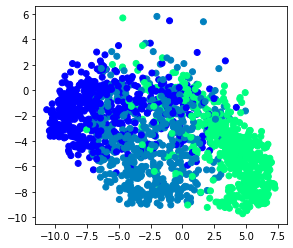

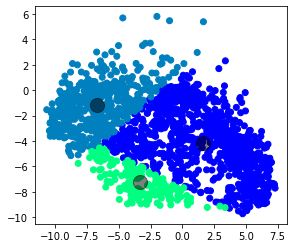

[array([0.77196262, 0.18878505, 0.03925234]), array([0.07978723, 0.89361702, 0.02659574]), array([0.13160734, 0.30312837, 0.56526429])]


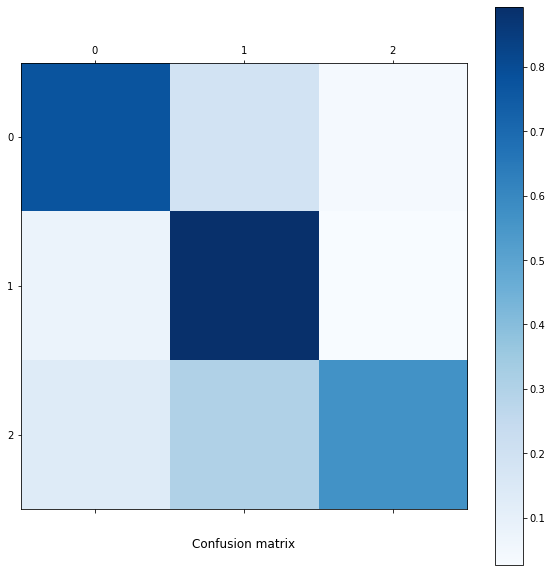

In [252]:
########## this is what we were asked to do ################
#means, clusters, labels_clustered = K_means(data, labels, 3, l_2_distance, 0.000001) 
#PCA_data, b = PCA(data)
#means_projected = means @ b


######### however doing it this way gives a LOT better results (cf report) ############
PCA_data, b = PCA(data)
means, clusters, labels_clustered = K_means(PCA_data, labels, 3, l_2_distance, 0.000001)


## CONFUSION MATRIX

def count (l): 
    r = np.array([0, 0, 0])
    for i in l:
        r[i] += 1
    return (np.argmax(r), r/len(l))

confusion_matrix = []

for sub in labels_clustered:
    confusion_matrix.append(count(sub))

plt.scatter(PCA_data[:, 0], PCA_data[:, 1], c=labels, cmap='winter')
plt.axis('scaled')
plt.show()

data_clustered = np.array([val for sublist in clusters for val in sublist])
labels_flatened = np.concatenate([i*np.ones(len(labels_clustered[i])) for i in range(len(labels_clustered))])
plt.scatter(data_clustered[:, 0], data_clustered[:, 1], c=labels_flatened, cmap='winter')
plt.scatter(means[:, 0], means[:, 1], c='red', s=200, alpha=0.5)
plt.axis('scaled')
plt.show()
    
confusion_matrix.sort()
confusion_matrix = [x[1] for x in confusion_matrix]
print(confusion_matrix)
plt.figure(figsize=(10, 10))
plt.matshow(confusion_matrix, cmap=plt.get_cmap("Blues"), fignum=1)
plt.title('Confusion matrix', y=-0.1)
plt.colorbar()
tick_marks = np.arange(3)

plt.show()